In [133]:
import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.utils.data
import matplotlib.pyplot as plt
from termcolor import colored
import os


data_path = './data.csv'

In [134]:
#random generate date function for validate
def generate_data():
    first_num = np.random.randint(low=0,high=30)
    second_num = np.random.randint(low=0,high=30)
    add = np.random.randint(low=0, high=100) 
    add2 = np.random.randint(low=0, high=100)
    if add <33:
        expression = str(first_num) + '+' + str(second_num)
        result = first_num+second_num
    elif add in range(33,66):
        expression = str(first_num) + '-' + str(second_num)
        result = first_num-second_num
    else :
        expression = str(first_num) + '*' + str(second_num)
        result = first_num*second_num
    
    third_num = np.random.randint(low=0,high=30)
    if add2 <33:
        expression = expression + '+' + str(third_num)+ "="
        result = result + third_num
    elif add2 in range(33,66):
        expression = expression + '-' + str(third_num)+ "="
        result = result - third_num
    else :
        expression = expression+ '*' + str(third_num) + "="
        if add <33:
            result = first_num+(second_num*third_num)
        elif add in range(33,66):
            result = first_num-(second_num*third_num)
        else:
            result = result * third_num
    #else:
    #    expression = str(first_num) + '/' + str(second_num)
    #    res = weird_division(first_num, second_num)
    #    result = str(round(res,2))

 
    return expression, result

generate_data()

('20*9+4=', 184)

In [135]:
df = pd.read_csv(os.path.join(data_path))
# 看一下前幾筆資料是什麼樣子

len(df)
#df=df[:640000]
df.head()

,src,tgt
0,13-18-24=,-29
1,12+29*26=,766
2,21-4+13=,30
3,6*5-9=,21
4,6*18*28=,3024


<h1> Preprocessing

In [136]:

df['tgt']=df['tgt'].astype(str)
df['tgt']

0         -29
1         766
2          30
3          21
4        3024
         ... 
39995    -303
39996    1134
39997    4466
39998     380
39999      30
Name: tgt, Length: 40000, dtype: object

<h1>建立字典

In [137]:
# 一個dict把字符轉化成id
char_to_id = {}
# 把id轉回字符
id_to_char = {}

# 有一些必須要用的special token先添加進來(一般用來做padding的token的id是0)
char_to_id['<pad>'] = 0
char_to_id['<eos>'] = 1
id_to_char[0] = '<pad>'
id_to_char[1] = '<eos>'

#char_to_id={'<pad>': 0, '<eos>': 1, '2': 2, '7': 3, '3': 4, '9': 5, '5': 6, '6': 7, '0': 8, '-': 9, '1': 10, '8': 11, '=': 12, '+': 13, '4': 14}
#id_to_char={0: '<pad>', 1: '<eos>', 2: '2', 3: '7', 4: '3', 5: '9', 6: '5', 7: '6', 8: '0', 9: '-', 10: '1', 11: '8', 12: '=', 13: '+', 14: '4'}

# 把所有資料集中出現的token都記錄到dict中

for char in set(df['src'].str.cat()):
    ch_id = len(char_to_id)
    char_to_id[char] = ch_id
    id_to_char[ch_id] = char

vocab_size = len(char_to_id)
print('字典大小: {}'.format(vocab_size))
print('char_to_index : ', char_to_id)
print('index_to_char : ', id_to_char)

字典大小: 16
char_to_index :  {'<pad>': 0, '<eos>': 1, '3': 2, '2': 3, '9': 4, '7': 5, '4': 6, '8': 7, '6': 8, '-': 9, '+': 10, '0': 11, '1': 12, '=': 13, '5': 14, '*': 15}
index_to_char :  {0: '<pad>', 1: '<eos>', 2: '3', 3: '2', 4: '9', 5: '7', 6: '4', 7: '8', 8: '6', 9: '-', 10: '+', 11: '0', 12: '1', 13: '=', 14: '5', 15: '*'}


In [138]:
# 把資料集的所有資料都變成id
df['src_char_id_list'] = df['src'].apply(lambda text: [char_to_id[char] for char in list(text)] )+df['tgt'].apply(lambda text: [char_to_id[char] for char in list(text)]+ [char_to_id['<eos>']] )

df[['src','tgt','src_char_id_list']].head()

,src,tgt,src_char_id_list,tgt_char_id_list
0,13-18-24=,-29,"[12, 2, 9, 12, 7, 9, 3, 6, 13, 9, 3, 4, 1]","[9, 3, 4, 1]"
1,12+29*26=,766,"[12, 3, 10, 3, 4, 15, 3, 8, 13, 5, 8, 8, 1]","[5, 8, 8, 1]"
2,21-4+13=,30,"[3, 12, 9, 6, 10, 12, 2, 13, 2, 11, 1]","[2, 11, 1]"
3,6*5-9=,21,"[8, 15, 14, 9, 4, 13, 3, 12, 1]","[3, 12, 1]"
4,6*18*28=,3024,"[8, 15, 12, 7, 15, 3, 7, 13, 2, 11, 3, 6, 1]","[2, 11, 3, 6, 1]"


# 超參數

|超參數|意義|數值|
|-|-|-|
|`batch_size`|單一 batch 的資料數|64|
|`epochs`|總共要訓練幾個 epoch|10|
|`embed_dim`|文字的 embedding 維度|50|
|`hidden_dim`|LSTM 中每個時間的 hidden state 維度|50|
|`lr`|Learning Rate|0.001|
|`grad_clip`|為了避免 RNN 出現梯度爆炸問題，將梯度限制範圍|1|

In [139]:
batch_size =400
epochs = 50
embed_dim = 256
hidden_dim = 256
lr = 0.001
grad_clip = 1

# 資料分批
- 使用 `torch.utils.data.Dataset` 建立資料產生的工具 `dataset`
- 再使用 `torch.utils.data.DataLoader` 對資料集 `dataset` 隨機抽樣並作為一個 batch


In [140]:
# 這裏的dataset是文本生成的dataset，輸入和輸出的資料都是文章
# 舉個例子，現在的狀況是：
# input:  A B C D E F 
# output: B C D E F <eos>
# 而對於加減法的任務：
# input:x 1 + 2 + 3 = 6  
#       y + 2 + 3 = 6 <eos>  
#         x:   5 +6 +7=18
#           y: + 6 +7=18<eos>  
# output: / / / / / 6 <eos>
# /的部分都不用算loss，主要是預測=的後面，這裏的答案是6，所以output是6 <eos>
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __getitem__(self, index):
        # input:  1 + 2 + 3 = 6
        # output: / / / / / 6 <eos>
        #x= 1+2+3=6
        #y= ppppp6<eos>
        #self.sequences.iloc[index] : 1+ 2+3=6<eos>
        x = self.sequences.iloc[index][:-1]
        y = self.sequences.iloc[index][1:]#self.sequences.iloc[index][self.sequences[index].index(char_to_id['='])+1:]
        # 找到=的索引
        index = y.index(char_to_id['='])
        # 將=左邊的元素設置為0
        y[:index+1] = [0] * (index+1)

        return x, y

    def __len__(self):
        return len(self.sequences)

def collate_fn(batch):

    batch_x = [torch.tensor(data[0]) for data in batch] # list[torch.tensor]
    batch_y = [torch.tensor(data[1]) for data in batch] # list[torch.tensor]
    batch_x_lens = torch.LongTensor([len(x) for x in batch_x])
    batch_y_lens = torch.LongTensor([len(y) for y in batch_y])
    equalidxs=torch.LongTensor([(data == char_to_id['=']).nonzero(as_tuple=True)[0] for data in batch_x])
    # torch.tensor
    # [[1968, 1891, 3580, ... , 0, 0, 0],
    #  [1014, 2242, 2247, ... , 0, 0, 0],
    #  [3032,  522, 1485, ... , 0, 0, 0]]
    #                       padding↑
    pad_batch_x = torch.nn.utils.rnn.pad_sequence(batch_x,
                                                  batch_first=True, # shape=(batch_size, seq_len)
                                                  padding_value=char_to_id['<pad>'])

    pad_batch_y = torch.nn.utils.rnn.pad_sequence(batch_y,
                                                  batch_first=True, # shape=(batch_size, seq_len)
                                                  padding_value=char_to_id['<pad>'])

    return pad_batch_x, pad_batch_y, batch_x_lens, batch_y_lens ,equalidxs

In [141]:
dataset = Dataset(df['src_char_id_list'])
train_data,val_data=torch.utils.data.random_split(dataset,[int(len(dataset) *0.8),int(len(dataset)*0.2)])

#train_data.shape

In [142]:
train_data.__getitem__(2)


([12, 12, 10, 3, 8, 15, 3, 12, 13, 14, 14, 5],
 [0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 5, 1])

In [143]:
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn
                                          )
val_data_loader = torch.utils.data.DataLoader(val_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn
                                          )

In [144]:
len(train_data_loader)

80

In [145]:
#for i,x in enumerate(data_loader,):
#    print(x)

# 模型設計

## 執行順序
1. 將句子中的所有字轉換成 embedding
2. 按照句子順序將 embedding 丟入 LSTM
3. LSTM 的輸出再丟給 LSTM，可以接上更多層
4. 最後的 LSTM 所有時間點的輸出丟進一層 Fully Connected
5. 輸出結果所有維度中的最大者即為下一個字

## 損失函數
因為是類別預測，所以使用 Cross Entropy

## 梯度更新
使用 Adam 演算法進行梯度更新

In [146]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()

        # Embedding層
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])
        
        # RNN層
        self.rnn_layer1 = torch.nn.LSTM(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)

        #self.rnn_layer2 = torch.nn.LSTM(input_size=hidden_dim,
        #                                hidden_size=hidden_dim,
        #                                batch_first=True)
        
        #self.rnn_layer3 = torch.nn.LSTM(input_size=hidden_dim,
        #                                hidden_size=hidden_dim,
        #                                batch_first=True)

        # output層
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))
        

    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)

    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)

        # 假設有個tensor : tensor([[1, 2, 3, 4],
        #                        [9, 0, 0, 0]])
        # 輸出就是：PackedSequence(data=tensor([1, 9, 2, 3, 4]),
        #                         batch_sizes=tensor([2, 1, 1, 1]),
        #                         sorted_indices=None, unsorted_indices=None)
        # torch.nn.utils.rnn.pack_padded_sequence 會把batch當中的句子從長到短排序，建立如上所示的資料結構
        # 就像上一個例子一樣，RNN會先吃第一個batch內的第一個batch_size，看到這個地方的batch_size爲2，所以此時RNN會吃兩個token，輸出一個2Xhidden_dim的向量組
        # 然後看第二個batch_size, 此時爲1，少了一個，說明其中一個序列到頭了，那就取上一個輸出向量的第一個，再生成一個1Xhidden_dim的向量
        # [
        # [1,2,3],                data = [1,4,6,2,5,3]   output  data = [1p,4p,6p,2p,5p,3p]             [1p,2p,3p]
        # [4,5,0], => pack_padded_sequence => batch_sizes = [3,2,1] => RNN => batch_sizes = [3,2,1] => pad_packed_sequence => [4p,5p,0]
        # [6,0,0]         _                                                     [6p,0,0]
        # ]
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)

        batch_x, _ = self.rnn_layer1(batch_x)
        #batch_x, _ = self.rnn_layer2(batch_x)
        #batch_x, _ = self.rnn_layer3(batch_x)

        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)

        batch_x = self.linear(batch_x)

        return batch_x
    
    def generator(self, start_chars, max_len=200):
        char_list = []
        for char in start_chars:
            char_list.append(char_to_id[char])
    

        next_char = None
        # Move initial character list to the device
        char_list_tensor = torch.LongTensor(char_list).unsqueeze(0).to(device)
        # 生成的長度沒達到max_len就一直生
        while len(char_list) < max_len:

            x = self.embedding(char_list_tensor)
            _, (ht, _) = self.rnn_layer1(x)
          #  _, (ht, _) = self.rnn_layer2(ht)
          #  _, (ht, _) = self.rnn_layer3(ht)
            y = self.linear(ht)
            
            next_char = np.argmax(y.detach().cpu().numpy())

            # 如果看到新的token是<eos>就說明生成結束了，就停下
            if next_char == char_to_id['<eos>']:
                break

            char_list.append(next_char)
            char_list_tensor = torch.LongTensor(char_list).unsqueeze(0).to(device)

        return [id_to_char[ch_id] for ch_id in char_list]

In [147]:
torch.manual_seed(3)


model = CharRNN(vocab_size,
                embed_dim,
                hidden_dim)
#model.load_state_dict(torch.load('./models/model_state_dict.pt'))
model=model.to(device)
print(model)

CharRNN(
  (embedding): Embedding(16, 256, padding_idx=0)
  (rnn_layer1): LSTM(256, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=16, bias=True)
  )
)


In [148]:
criterion = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=char_to_id['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 訓練
1. 最外層的 `for` 迴圈控制 `epoch`
    1. 內層的 `for` 迴圈透過 `data_loader` 取得 batch
        1. 丟給 `model` 進行訓練
        2. 預測結果 `batch_pred_y` 跟真正的答案 `batch_y` 進行 Cross Entropy 得到誤差 `loss`
        3. 使用 `loss.backward` 自動計算梯度
        4. 使用 `torch.nn.utils.clip_grad_value_` 將梯度限制在 `-grad_clip` &lt; &lt; `grad_clip` 之間
        5. 使用 `optimizer.step()` 進行更新（back propagation）
2. 每 `1000` 個 batch 就輸出一次當前的 loss 觀察是否有收斂的趨勢

In [149]:
from tqdm import tqdm
model = model.to(device)
model.train()
test_acc = []
val_losses = []
train_losses = []
i = 0
j = 0
losstemp=0
for epoch in range(1, epochs+1):
    process_bar = tqdm(train_data_loader, desc=f"Training epoch {epoch}")
    
    for batch_x, batch_y, batch_x_lens, batch_y_lens,eqidex in process_bar:
        #print(batch_x)
        # 標準DL訓練
        
        optimizer.zero_grad()

        batch_pred_y = model(batch_x.to(device), batch_x_lens)

        #print(batch_pred_y)
        batch_pred_y=batch_pred_y[:, : ,:]
        #print(batch_pred_y.shape)
        batch_pred_y =  batch_pred_y.reshape(batch_size*batch_pred_y.shape[1],vocab_size)

        #print(batch_pred_y.shape)
        #print(batch_pred_y.shape)
        #print(batch_y)
        batch_y=batch_y.reshape(-1).to(device)
        #print(batch_y)
        # 計算損失          
        
        
        loss = criterion(batch_pred_y, batch_y)
        loss.backward() 
        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        
        
        i+=1
        losstemp+=loss.item()
        if i%20==0:
            process_bar.set_postfix(loss=loss.item())
            
            
    train_losses.append(losstemp)
    #validation
    losstemp=0
    for batch_x, batch_y, batch_x_lens, batch_y_lens,eqidex in val_data_loader:

        
        optimizer.zero_grad()

        batch_pred_y = model(batch_x.to(device), batch_x_lens)

        #print(batch_pred_y)
        batch_pred_y=batch_pred_y[:, : ,:]
        #print(batch_pred_y.shape)
        batch_pred_y =  batch_pred_y.reshape(batch_size*batch_pred_y.shape[1],vocab_size)
        
        #print(batch_pred_y.shape)
        #print(batch_pred_y.shape)
        #print(batch_y)
        batch_y=batch_y.reshape(-1).to(device)
        #print(batch_y)
        # 計算損失          
        
        j+=1
        losstemp+=loss.item()
        loss = criterion(batch_pred_y, batch_y)
        
    val_losses.append(losstemp*4)
        
        
    #每個epoch test acc一次
    #if(epoch==0):
    validation_process_bar = tqdm(range(50))
    correctCount=0
    for i in validation_process_bar:
        expression,result=generate_data()
        pred = model.generator(expression)
        
        genStr=""
        for x in pred: 
            genStr+= x 
    
        #print(expression,result,genStr) 
        if(genStr==expression+str(result)):
            #print(expression,genStr)
            correctCount=correctCount+1
    #print("acc="+str(correctCount/50.0)) 
    test_acc.append(correctCount/50.0)

    #如果訓練到500 epoch要儲存一下
    if(epoch%500==0):
        torch.save(model, './models/model_epoch'+str(epoch)+'.pt')
           
        

100%|██████████| 50/50 [00:00<00:00, 377.16it/s]


In [150]:
genStr=model.generator('10+12*13=')
print(genStr)

['1', '0', '+', '1', '2', '*', '1', '3', '=', '1', '6', '6']


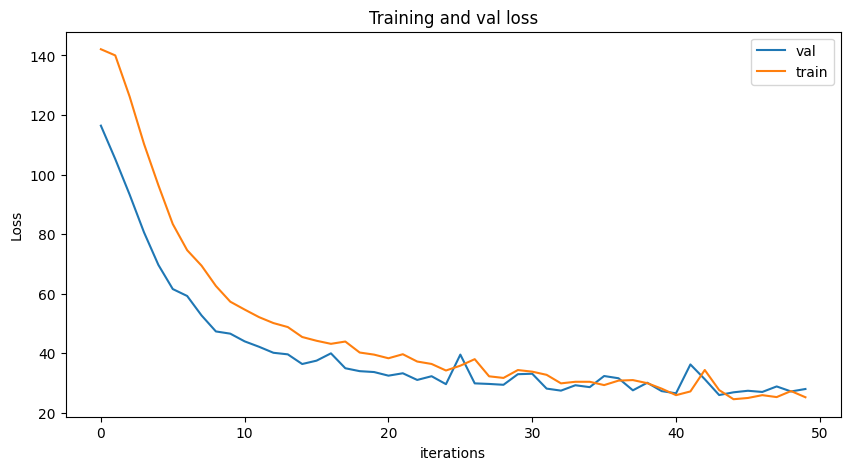

In [151]:
plt.figure(figsize=(10,5))
plt.title("Training and val loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

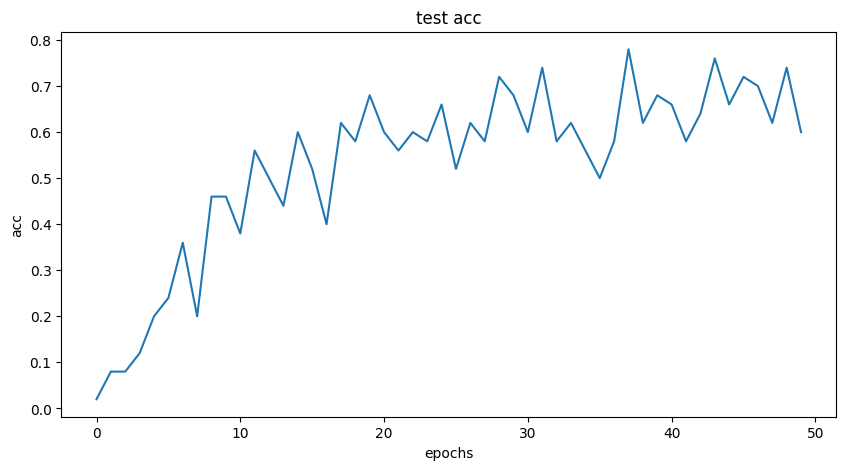

In [152]:
plt.figure(figsize=(10,5))
plt.title("test acc")
plt.plot(test_acc)
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()


In [163]:
#手動跑一次random test
validation_process_bar = tqdm(range(100))
correctCount=0
for i in validation_process_bar:
    expression,result=generate_data()
    
    pred = model.generator(expression)
    
    genStr=""
    for x in pred: 
         genStr+= x 
    
    
    if(genStr==expression+str(result)):
        
        print(colored(genStr,'green'),colored(result,'green'))
        correctCount=correctCount+1
    else:
        print(genStr,result)
print("acc="+str(correctCount/100.0))       

 49%|████▉     | 49/100 [00:00<00:00, 242.49it/s]

8+24-10=22 22
24-13+20=31 31
18-23+10=5 5
26-24+0=2 2
1*13-2=11 11
9-1-7=1 1
3+12*2=27 27
25-11+21=35 35
17*20+4=344 344
28+22+7=57 57
13+2+19=34 34
23*18+11=425 425
2-24+21=-3 -1
12*11*10=1360 1320
8*14*19=2152 2128
20+21*14=326 314
2+29-24=7 7
10-8*22=-162 -166
23+2+18=43 43
17-26-14=-21 -23
14*16+20=244 244
16*6*20=1920 1920
16*9+12=156 156
22-13*0=24 22
28-16+18=30 30
1+2+21=24 24
14+10-25=-1 -1
25-27+29=27 27
7+7+22=36 36
1+3-22=-16 -18
27+2*27=81 81
20+1+1=22 22
29*20+25=615 605
19-29-24=-32 -34
24+17-28=13 13
5+10-3=12 12
16-3*27=-65 -65
21-4+18=35 35
16+16+23=55 55
16-1-5=10 10
27-27+19=19 19
15-1-17=-3 -3
26-8-25=-7 -7
25+6+13=44 44
1+24*24=587 577
19+29*1=48 48
2*5-3=7 7
7+1+21=29 29
15*24*0=0 0


100%|██████████| 100/100 [00:00<00:00, 277.39it/s]

19*14+21=295 287
20-11-18=-9 -9
4+14*24=336 340
0-10+18=8 8
10*24-6=234 234
26+12+16=54 54
25+27+28=80 80
12*2*21=504 504
25+26-22=29 29
18-24-13=-19 -19
22-9-6=7 7
25*18*11=4850 4950
2-0-3=1 -1
12+1*23=35 35
10+15*12=180 190
26-11+22=37 37
18+11-25=4 4
12+21-19=14 14
7*11-8=69 69
7-8-6=-5 -7
5*16+9=89 89
7+3*7=26 28
28*18-5=499 499
3-20-3=-20 -20
25+8-17=16 16
19+0+24=43 43
19+17-3=33 33
4+22*15=326 334
26+2+5=33 33
4-21*17=-349 -353
21-23-21=-21 -23
18*6*2=224 216
9-29-24=-44 -44
2-2-9=-9 -9
11+5*29=152 156
23+2-11=14 14
25-0+20=45 45
26-5-19=2 2
12*10+6=124 126
24*26*19=12312 11856
26+15+20=61 61
9+7+25=41 41
25+4-7=22 22
15+12-4=23 23
4-1-6=-3 -3
20-17+5=8 8
8-14+9=3 3
20*21-4=424 416
10*27-4=256 266
8*5-19=17 21
15+0*8=15 15
acc=0.72


# 測試在脫離data set範圍的情況下 準確率怎麼樣

In [154]:
#random generate date function for validate
def diff_generate_data():
    first_num = np.random.randint(low=0,high=50)
    second_num = np.random.randint(low=0,high=50)
    add = np.random.randint(low=0, high=100) 
    add2 = np.random.randint(low=0, high=100)
    if add <33:
        expression = str(first_num) + '+' + str(second_num)
        result = first_num+second_num
    elif add in range(33,66):
        expression = str(first_num) + '-' + str(second_num)
        result = first_num-second_num
    else :
        expression = str(first_num) + '*' + str(second_num)
        result = first_num*second_num
    
    third_num = np.random.randint(low=0,high=50)
    if add2 <33:
        expression = expression + '+' + str(third_num)+ "="
        result = result + third_num
    elif add2 in range(33,66):
        expression = expression + '-' + str(third_num)+ "="
        result = result - third_num
    else :
        expression = expression+ '*' + str(third_num) + "="
        if add <33:
            result = first_num+(second_num*third_num)
        elif add in range(33,66):
            result = first_num-(second_num*third_num)
        else:
            result = result * third_num
    

 
    return expression, result

diff_generate_data()

('39+31+12=', 82)

In [155]:
validation_process_bar = tqdm(range(100))
correctCount=0
for i in validation_process_bar:
    expression,result=diff_generate_data()
    
    pred = model.generator(expression)
    
    genStr=""
    for x in pred: 
         genStr+= x 


    if(genStr==expression+str(result)):
        
        print(colored(genStr,'green'),colored(result,'green'))
        correctCount=correctCount+1
    else:
        print(genStr,result)
print("acc="+str(correctCount/100.0))       

  0%|          | 0/100 [00:00<?, ?it/s]

27*34+28=255 946
44+4-31=3 17
22-28*10=-266 -258
5-13+37=7 29
7*38*42=726 11172
36-21*0=17 36
12*18*18=3788 3888
39*30+2=87 1172
25*29+45=710 770
15*8-29=93 91
43*46+25=99 2003
33-28*29=-799 -779
6-1+30=13 35
21*48-4=1420 1004
40-31*45=-91 -1355
13*43+28=114 587
37+39-36=18 40
41*24-11=155 973
45+30+1=22 76
29-6-46=1 -23
15-41+4=9 -22
12-32+9=11 -11
16+40-5=19 51
2*0+38=17 38
3-3-24=-24 -24
28*12-19=327 317
19+42+30=37 91


 79%|███████▉  | 79/100 [00:00<00:00, 386.93it/s]

26*25*12=7100 7800
40-30*16=-88 -440
5*35*9=475 1575
34+15+2=29 51
10*26*39=2466 10140
48*48+5=113 2309
7+29*44=163 1283
47-22+45=7 70
45+0+35=26 80
8*38*15=1260 4560
49+8*43=90 393
26*38-46=310 942
38*15*21=2660 11970
41+29*25=713 766
6-42*42=96 -1758
27+4*24=119 123
40-26+14=-8 28
24-28*14=-366 -368
12*45-28=78 512
3*43+12=55 141
18-35-19=-18 -36
40*6*30=120 7200
8+7+8=23 23
30*5+16=41 166
25*12-6=294 294
44*49*26=1584 56056
14-15-28=-29 -29
45+22-1=33 66
49-0-10=10 39
22+40*47=92 1902
10*10*33=310 3300
33*5+34=53 199
9+48+19=46 76
4-7*41=-71 -283
8-22*48=-164 -1048
5+40+10=25 55
34*11+24=90 398
41-41*21=-155 -820
33-33-29=-33 -29
37+7*21=140 184
46+28-6=36 68
13+8-39=-2 -18
49-18+32=13 63
8+7+12=27 27
36-33-39=-17 -36
18-29*0=18 18
43-0-22=-10 21
21+10*43=91 451
5*34-27=29 143
9-27*46=-159 -1233
33+47-18=11 62
25-15-22=-12 -12


100%|██████████| 100/100 [00:00<00:00, 381.33it/s]

45*27+48=168 1263
0*44+26=26 26
35*45+21=107 1596
40*27-22=74 1058
6+41*9=79 375
22*48+15=169 1071
18+39*30=81 1188
26*9+49=237 283
44*43+12=84 1904
40-30-20=-26 -10
2*32-39=7 25
20-42*32=-96 -1324
39*23*13=2867 11661
28-22-24=-16 -18
45*39*21=1447 36855
16*16*32=2116 8192
25-9-12=4 4
14*1+19=33 33
39*38-37=90 1445
41*40*16=720 26240
11*6+36=77 102
acc=0.1
